In [ ]:
# ### mount on google drive if you running the code on colab
# from google.colab import drive
# drive.mount('/content/drive/')
# import os
# os.chdir("/content/drive/My Drive/WatNet/notebooks")


In [1]:
import os
from osgeo import gdal
os.chdir('..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# had to change utils to my_utils cause it has the same name with the one in my python environment 
from my_utils.geotif_io import readTiff, writeTiff
from my_utils.acc_pixel import acc_matrix
from watnet_infer import watnet_infer
# pip install tensorflow


In [2]:
import sys
# sys.path.append('h:\\My Drive\\Code\\Projects\\WatNet\\my_utils')  # Replace '/path/to/parent/directory' with the actual path
# print(sys.path)
# sys.path.append('h:\\My Drive\\Code\\Projects\\WatNet') 
# sys.path.append('h:\\My Drive\\Code\\Projects\\WatNet\\notebooks') 
# print(sys.path)
# # Remove a specific directory from sys.path
# path_to_remove = '/path/to/remove'
# if path_to_remove in sys.path:
#     sys.path.remove(path_to_remove)
# Get the current working directory and print 
current_directory = os.getcwd()
print("Current Directory:", current_directory)

Current Directory: h:\My Drive\Code\Projects\WatNet


In [3]:
## test image and test sample
path_S2_img = "H:/My Drive/Projects/Beavers/Beaver_EarthEngine/Sentinel2_6Bands_WatNet/S2MSI_L2A_PolygonA_6Bands.tif"
# pre-trained model
watnet_model = 'H:/My Drive/Code/Projects/WatNet/model/pretrained/watnet.h5'
path_result_map = "H:/My Drive/Projects/Beavers/Beaver_EarthEngine/Sentinel2_6Bands_WatNet/S2MSI_L2A_PolygonA_6Bands_water.tif"
## super parameters
patch_size = 512
overlay = 80  # the overlay area between neighboring patches


In [ ]:
# this is not from watnet, wanted to check the bands 
def count_bands(tif_path):
    try:
        dataset = gdal.Open(tif_path)
        if dataset is None:
            print("Unable to open", tif_path)
            return None
        else:
            num_bands = dataset.RasterCount
            print("Number of bands:", num_bands)
            return num_bands
    except Exception as e:
        print("Error:", e)

def print_band_info(tif_path):
    try:
        dataset = gdal.Open(tif_path)
        if dataset is None:
            print("Unable to open", tif_path)
            return None
        else:
            num_bands = dataset.RasterCount
            print("Number of bands:", num_bands)
            for band_num in range(1, num_bands + 1):
                band = dataset.GetRasterBand(band_num)
                print("Band", band_num, "information:")
                print("  Type:", gdal.GetDataTypeName(band.DataType))
                # print("  Minimum value:", band.GetMinimum())
                # print("  Maximum value:", band.GetMaximum())
                # print("  NoData value:", band.GetNoDataValue())
                print("  Color interpretation:", gdal.GetColorInterpretationName(band.GetColorInterpretation()))
                # print("  Scale factor:", band.GetScale())
                # print("  Offset:", band.GetOffset())
                # print("  Unit type:", band.GetUnitType())
                print("  Metadata:", band.GetMetadata())
                print("  Description:", band.GetDescription())
                # print("")

    except Exception as e:
        print("Error:", e)

def check_nir_band(raster_path):
    # Open the raster dataset
    dataset = gdal.Open(raster_path)

    if dataset is None:
        print("Error: Unable to open raster dataset.")
        return False

    # Get the number of bands
    num_bands = dataset.RasterCount

    # Check if the NIR band is present
    for i in range(1, num_bands + 1):
        band = dataset.GetRasterBand(i)
        metadata = band.GetMetadata()

        # Check the band description or color interpretation
        band_desc = metadata.get('description', '')
        color_interp = band.GetColorInterpretation()

        if 'NIR' in band_desc or color_interp == gdal.GCI_GrayIndex:
            print(f"NIR band found in band {i}.")
            return True

    print("NIR band not found in the raster.")
    return False

In [12]:
# Replace 'path_to_your_tif_file.tif' with the actual path to your TIFF file
tif_path = 'H:/My Drive/Data/Others/dset-s2/dset-s2/tra_scene/S2A_L2A_20190125_N0211_R034_6Bands_S1.tif'
raster_path = "H:/My Drive/Projects/Beavers/Beaver_EarthEngine/Sentinel2_6Bands_WatNet/S2MSI_L2A_PolygonA_6Bands.tif"

In [13]:
count_bands(tif_path)
count_bands(raster_path)

Number of bands: 6
Number of bands: 6


6

In [17]:
# print_band_info(tif_path)
print_band_info(raster_path)

Number of bands: 6
Band 1 information:
  Type: UInt16
  Color interpretation: Gray
  Metadata: {'STATISTICS_COUNT': '92267.000000', 'STATISTICS_COVARIANCES': '23963.93719768997,30849.13952581035,39848.54367733292,65000.50549172863,107015.9369247509,84973.98115655604', 'STATISTICS_MAXIMUM': '2194', 'STATISTICS_MEAN': '223.3405009375', 'STATISTICS_MEDIAN': '206.494118', 'STATISTICS_MINIMUM': '0', 'STATISTICS_SKIPFACTORX': '1', 'STATISTICS_SKIPFACTORY': '1', 'STATISTICS_STDDEV': '154.80289789823'}
  Description: Band_1
Band 2 information:
  Type: UInt16
  Color interpretation: Undefined
  Metadata: {'STATISTICS_COUNT': '92267.000000', 'STATISTICS_COVARIANCES': '30849.13952581035,44679.59663851903,52687.18785509768,127571.944425843,153974.6037136916,112810.7693344673', 'STATISTICS_MAXIMUM': '2666', 'STATISTICS_MEAN': '362.96649939848', 'STATISTICS_MEDIAN': '386.831373', 'STATISTICS_MINIMUM': '0', 'STATISTICS_SKIPFACTORX': '1', 'STATISTICS_SKIPFACTORY': '1', 'STATISTICS_STDDEV': '211.375487

In [15]:
check_nir_band(tif_path)
check_nir_band(raster_path)

NIR band not found in the raster.
NIR band found in band 1.


True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


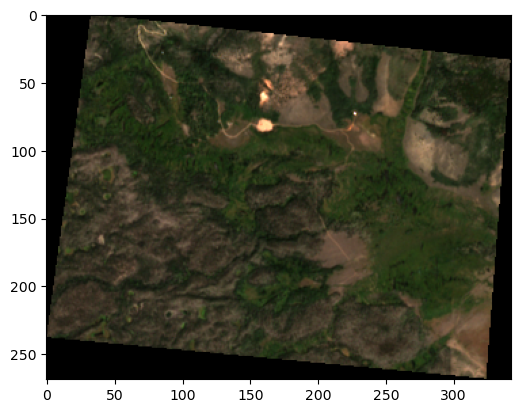

In [4]:
# -----Load and prepare the satellite image data -----#
sen2_img, img_info = readTiff(path_in=path_S2_img)
sen2_img = np.clip(sen2_img/10000, a_min=0, a_max=1) ## normalization
plt.figure(figsize=(6,6))
plt.imshow(sen2_img[:, :, (2,1,0)]*5)
# TypeError: only size-1 arrays can be converted to Python scalars
    # sen2_img = float(np.clip(sen2_img/10000, a_min=0, a_max=1))  ## normalization  



# print(np.__version__)

# resolve an issue 
#     x = np.float(3.14)
#     x = float(3.14)
#     print(x)

In [5]:
### ---- surface water mapping by using pretrained watnet.
water_map = watnet_infer(rsimg=sen2_img, path_model = watnet_model)


ValueError: zero-size array to reduction operation minimum which has no identity

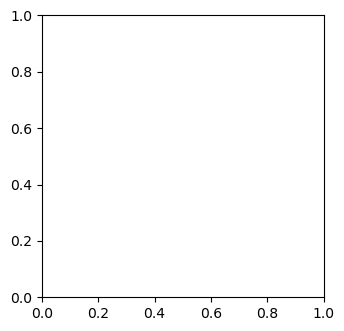

In [6]:
### show the result
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(sen2_img[1500:2000, 1000:1500, (3,2,1)]*6.5)
plt.subplot(1,2,2)
plt.imshow(water_map[1500:2000, 1000:1500, 0])


In [7]:
## show the accuracy
path_sam = 'H:/My Drive/Code/Projects/WatNet/data/test-demo/val_sam.csv'
df_sam = pd.read_csv(path_sam, header=0)
acc_oa, acc_prod, acc_user, confus_mat = acc_matrix(water_map, df_sam.to_numpy(), id_label=1)
print('OA:', acc_oa)
print('Producer acc:', acc_prod)
print('user acc:', acc_user)
print('Confusion matrix:', np.around(confus_mat,4))
plt.matshow(confus_mat,cmap=plt.cm.Greys, fignum=0)
plt.colorbar()


IndexError: index 2207 is out of bounds for axis 1 with size 343

### Save the result.

In [74]:
img_info

{'geoextent': (738710.0, 761530.0, 2544530.0, 2564600.0),
 'geotrans': (738710.0, 10.0, 0.0, 2564600.0, 0.0, -10.0),
 'geosrs': '32649',
 'row': 2007,
 'col': 2282,
 'bands': 6}

In [75]:
# # save the result
writeTiff(im_data = water_map.astype(np.int8), 
          im_geotrans = img_info['geotrans'], 
          im_geosrs = img_info['geosrs'], 
          path_out = path_result_map)
